In [1]:
import fastjet as fj
import pythia8
from pythiafjtools import pypythiafjtools as pyfj
from lundplane import pylundplane as lund
from mptools import pymptools as mpt
from tqdm import tqdm
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
plt.style.use('seaborn-whitegrid')
# %config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import os
import re
import numpy as np
import pandas as pd

In [2]:
def create_and_init_pythia(config_strings=[]):
	pythia = pythia8.Pythia()
	for s in config_strings:
		pythia.readString(s)
	for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
		pythia.readString(extra_s)
	if pythia.init():
		return pythia
	return None


In [62]:
sconfig_pythia_w = ["Beams:eCM = 5000.", "HardQCD:all = on",
                    "PartonLevel:ISR = off",
                    "PartonLevel:MPI = off",
                    "PhaseSpace:bias2Selection=on",
                    "PhaseSpace:bias2SelectionPow=4",
                    "PhaseSpace:bias2SelectionRef=50"]
sconfig_pythia = ["Beams:eCM = 5000.", "HardQCD:all = on",
                    "PartonLevel:ISR = off",
                    "PartonLevel:MPI = off",
                    "PhaseSpace:pThatMin = 20"]
pythia = create_and_init_pythia(sconfig_pythia)

# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(10.0) & fj.SelectorAbsEtaMax(2 - jet_R0 * 1.05)


In [63]:
all_jets = []
x1 = []
x2 = []
id1 = []
id2 = []
pthat = []
ijet = 0
for iEvent in tqdm_notebook(range(10000), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -10, 10, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)
    _x1 = pythia.info.x1()
    _x2 = pythia.info.x2()
    _id1 = pythia.info.id1()
    _id2 = pythia.info.id2()
    _pthat = pythia.info.pTHat()
    x1.extend([_x1 for j in jets])
    x2.extend([_x2 for j in jets])
    id1.extend([_id1 for j in jets])
    id2.extend([_id2 for j in jets])
    pthat.extend([_pthat for j in jets])


In [64]:
pts = [j.pt() for j in all_jets]
etas = [j.eta() for j in all_jets]

In [65]:
jpd = pd.DataFrame({'pt' : pts, 'eta' : etas, 'x1' : x1, 'x2' : x2, 'id1' : id1, 'id2' : id2, 'pthat' : pthat})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129548fd0>,
      dtype=object)

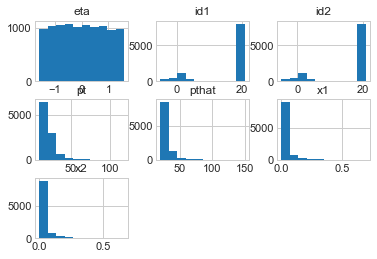

In [66]:
jpd.hist()

In [67]:
jpd.head()

,pt,eta,x1,x2,id1,id2,pthat
0,60.761189,-0.702540,0.081539,0.029138,21,21,67.392764
1,16.489137,-1.359313,0.099699,0.022415,1,21,31.780276
2,10.479643,-0.336069,0.099699,0.022415,1,21,31.780276
3,20.134077,1.153677,0.018383,0.082147,21,21,26.328192
4,21.468429,-1.573240,0.004116,0.032589,21,-1,25.247961


In [68]:
jpd.describe()

,pt,eta,x1,x2,id1,id2,pthat
count,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000,10199.000000
mean,20.854044,-0.010325,0.035246,0.036083,16.673399,16.535249,27.634485
std,8.799181,0.900428,0.059519,0.060738,8.424422,8.517768,9.618146
min,10.001088,-1.578583,0.000860,0.000797,-5.000000,-5.000000,19.772683
25%,15.545453,-0.775934,0.006631,0.006685,21.000000,21.000000,21.867966
50%,19.006468,-0.015238,0.014936,0.015539,21.000000,21.000000,24.545419
75%,23.542672,0.765444,0.034902,0.035451,21.000000,21.000000,29.715012
max,118.545740,1.579342,0.697544,0.665371,21.000000,21.000000,150.213885


Text(0, 0.5, '$p_{T}^{\\rm{jet}}$')

<Figure size 432x288 with 0 Axes>

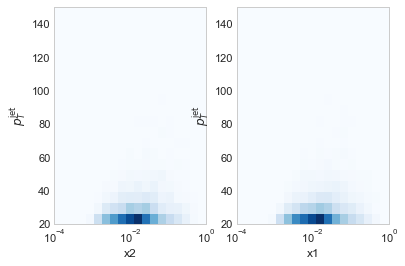

In [69]:
x1a = np.array(x1)
fig = plt.figure()
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.set_xscale('log')
ax0.set_xlabel('x2')
ax0.set_ylabel(r'$p_{T}^{\rm{jet}}$')
h0 = ax0.hist2d(x1, pthat, bins=(np.logspace(np.log10(1e-4),np.log10(1.0), 20), 20), cmap='Blues')
ax1.set_xscale('log')
h1 = ax1.hist2d(x2, pthat, bins=(np.logspace(np.log10(1e-4),np.log10(1.0), 20), 20), cmap='Blues', label="pT vs x2")
ax1.set_xlabel('x1')
ax1.set_ylabel(r'$p_{T}^{\rm{jet}}$')


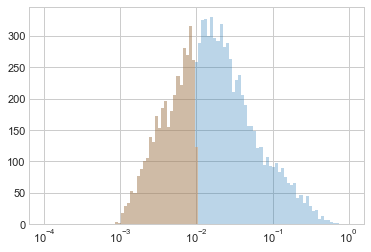

In [107]:
import pylab as pl
pl.hist(x1, bins=np.logspace(np.log10(1e-4),np.log10(1.0), 100), alpha=0.3)
pl.hist([xtmp for xtmp in x1 if xtmp < 0.01], bins=np.logspace(np.log10(1e-4),np.log10(1.0), 100), alpha=0.3)
pl.gca().set_xscale("log")
pl.show()

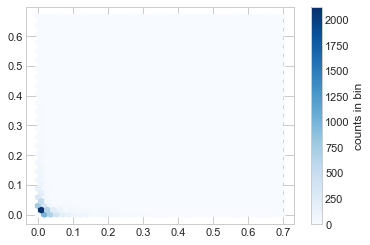

In [110]:
polys = plt.hexbin(x1, x2, gridsize=40, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

,pt,eta,x1,x2,id1,id2,pthat
count,2795.000000,2795.000000,2795.000000,2795.000000,2795.000000,2795.000000,2795.000000
mean,23.784301,-0.024082,0.036127,0.033576,16.093739,16.601431,32.117598
std,12.121028,0.963964,0.052786,0.047448,8.855991,8.491732,13.844700
min,10.001558,-1.577909,0.010005,0.010001,-5.000000,-5.000000,20.002593
25%,16.180883,-0.916385,0.013371,0.013318,21.000000,21.000000,23.326621
50%,20.674274,-0.075334,0.018618,0.018593,21.000000,21.000000,27.735477
75%,27.473892,0.865531,0.034268,0.031422,21.000000,21.000000,35.188440
max,118.545740,1.579342,0.560593,0.578761,21.000000,21.000000,150.213885


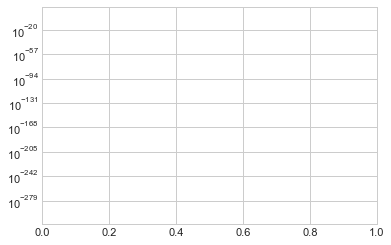

In [111]:
plt.yscale("log")
high_x_jpd = jpd.loc[(jpd['x1'] > 0.01) & (jpd['x2'] > 0.01)]
high_x_jpd.describe()

In [112]:
all_jets_pt = jpd['pt']
high_x_all_jets_pt = high_x_jpd['pt']

10199

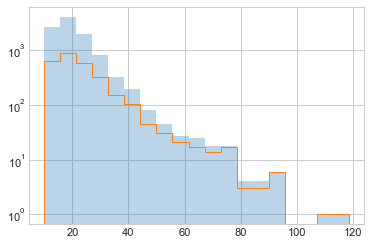

In [113]:
plt.yscale('log')
b, x, ax = plt.hist(all_jets_pt, bins=19, alpha=0.3)
b, x, ax = plt.hist(high_x_all_jets_pt, bins=19, alpha=1.0, histtype='step')
len(all_jets)

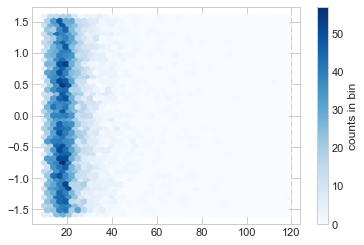

In [73]:
polys = plt.hexbin([j.pt() for j in all_jets], [j.eta() for j in all_jets], gridsize=40, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')